In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import matplotlib as mpl


In [2]:
mpl.rcParams.update({
    "font.family":        "sans-serif",
    "font.sans-serif":    ["Arial"],
    "font.size":          7.5,
    "axes.titlesize":     7.5,
    "axes.labelsize":     7.0,
    "xtick.labelsize":    7.0,
    "ytick.labelsize":    7.0,
    "legend.fontsize":    6.5,

    "axes.linewidth":     0.6,
    "xtick.direction":    "out",
    "ytick.direction":    "out",
    "xtick.major.size":   3.0,
    "xtick.major.width":  0.6,
    "ytick.major.size":   3.0,
    "ytick.major.width":  0.6,
    "xtick.minor.size":   1.5,
    "xtick.minor.width":  0.5,
    "ytick.minor.size":   1.5,
    "ytick.minor.width":  0.5,
    "xtick.minor.visible": False,
    "ytick.minor.visible": True,
    "xtick.major.pad":    3,
    "ytick.major.pad":    3,

    "axes.labelpad":      4,
    "axes.titlepad":      4,

    "lines.linewidth":    0.6,
    "axes.grid":          False,

    "savefig.dpi":        300,
    "savefig.bbox":       "tight",
})

In [3]:
# ================== Paths and site config ==================
site = 'AU-Preston'

mod_nam = ['f_sr', 'f_olrg', 'f_rnet', 'f_fsena', 'f_lfevpa', 'f_fgrnd']
obs_nam = ['SWup', 'LWup', 'Rnet', 'Qh', 'Qle', 'Qg']

# 5 groups: Slab, Urb, Urb_Veg (NoIrr), Urb_Veg, G11_Best
R_mod1     = np.zeros((5, 6), dtype=float)
RMSE_mod1  = np.zeros((5, 6), dtype=float)
MBE_mod1   = np.zeros((5, 6), dtype=float)

veg_f      = f'../model_output/veg/{site}/history/'
veg_noirr  = f'../model_output/no_irr/{site}/history/'
noveg_f    = f'../model_output/urb/{site}/history/'
slab_f     = f'../model_output/slab/{site}/history/'
obs_f      = f'../model_output/obs/'

In [4]:
# ================== Metrics function ==================
def calculate_metrics(observed, predicted):
    """Calculate R, RMSE, MBE, and standard deviations."""
    observed_  = np.asarray(observed).flatten()
    predicted_ = np.asarray(predicted).flatten()
    valid = ~np.isnan(observed_) & ~np.isnan(predicted_)
    observed_  = observed_[valid]
    predicted_ = predicted_[valid]

    if len(observed_) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    if np.std(observed_) == 0 or np.std(predicted_) == 0:
        R = np.nan
    else:
        R, _ = pearsonr(observed_, predicted_)

    rmse   = np.sqrt(mean_squared_error(observed_, predicted_))
    mod_sd = np.std(predicted_)
    obs_sd = np.std(observed_)
    mbe    = np.mean(predicted_ - observed_)

    return R, rmse, mbe, mod_sd, obs_sd

In [5]:
# ================== Plotting function (bar plots) ==================
def plot_g11(ax, r, rmse, mbe, rmse_changes, var_plot):
    """
    Draw RMSE bar plot for either radiation (SWup/LWup/Rnet) or turbulent (Qh/Qle/Qg).
    Returns handles/labels for figure-level legend.
    """
    barWidth = 0.14
    models = ['Slab', 'Urb', 'Urb_Veg (NoIrr)', 'Urb_Veg', 'G11_Best']

    # Fixed colors (NoIrr and Veg distinct)
    colors = ['#DB9850', '#3B5387', '#D94738', '#6BB48F', 'dimgray']

    if var_plot == 'radiation':
        cols = obs_nam[0:3]
    else:
        cols = obs_nam[3:]

    rmse_df = pd.DataFrame(rmse, columns=cols, index=models)

    r1 = np.arange(3)
    r2 = r1 + barWidth
    r3 = r2 + barWidth
    r4 = r3 + barWidth
    r5 = r4 + barWidth

    list1 = rmse_df.loc['Slab'].values
    list2 = rmse_df.loc['Urb'].values
    list3 = rmse_df.loc['Urb_Veg (NoIrr)'].values
    list4 = rmse_df.loc['Urb_Veg'].values
    list5 = rmse_df.loc['G11_Best'].values

    ax.bar(r1, list1, color=colors[0], width=barWidth, edgecolor='black', linewidth=0.6,
           label=r'$\mathregular{Slab}$', zorder=5)
    ax.bar(r2, list2, color=colors[1], width=barWidth, edgecolor='black', linewidth=0.6,
           label=r'$\mathregular{Urb}$', zorder=5)
    ax.bar(r3, list3, color=colors[2], width=barWidth, edgecolor='black', linewidth=0.6,
           label=r'$\mathregular{Urb_{Veg}\ (\text{No Irr})}$', zorder=5)
    ax.bar(r4, list4, color=colors[3], width=barWidth, edgecolor='black', linewidth=0.6,
           label=r'$\mathregular{Urb_{Veg}}$', zorder=5)
    ax.bar(r5, list5, color=colors[4], width=barWidth, edgecolor='black', linewidth=0.6,
           label=r'$\mathregular{G11_{Best}}$', zorder=5)

    ax.tick_params(axis='x', which='both', width=0, length=0, top=False)
    ax.set_xlim(-0.3, 2.8 + barWidth)
    ax.set_xticks(r1 + 2.0 * barWidth)

    if var_plot == 'radiation':
        x_label = ['$SW_{up}$', '$LW_{up}$', '$R_{net}$']
        ax.set_title('(a) Radiative flux', loc='left', fontweight='bold')
        y = [0, 5, 10, 15, 20, 25, 30, 35, 40]
        ax.set_ylim(0, 40)
    else:
        x_label = ['$Q_h$', '$Q_{le}$', '$Q_g$']
        ax.set_title('(b) Turbulent flux', loc='left', fontweight='bold')
        y = [0, 10, 20, 30, 40, 50, 60, 70, 80]
        ax.set_ylim(0, 80)

    ax.set_xticklabels(x_label)
    ax.set_yticks(y)
    ax.set_yticklabels([str(v) for v in y])
    ax.set_ylabel(r'RMSE (W m$^{-2}$)')

    # annotate best models on G11_Best bars (vertical)
    for ii in range(3):
        if var_plot == 'radiation':
            if ii == 0 and np.isfinite(list5[ii]):
                ax.text(r5[ii], list5[ii] + 1.0, "Model 33",
                        ha='center', va='bottom', rotation=90, color='black', fontsize=7)
            if ii == 1 and np.isfinite(list5[ii]):
                ax.text(r5[ii], list5[ii] + 1.0, "Model 46",
                        ha='center', va='bottom', rotation=90, color='black', fontsize=7)
            if ii == 2 and np.isfinite(list5[ii]):
                ax.text(r5[ii], list5[ii] + 1.0, "Model 36",
                        ha='center', va='bottom', rotation=90, color='black', fontsize=7)
        else:
            if ii == 0 and np.isfinite(list5[ii]):
                ax.text(r5[ii], list5[ii] + 4.0, "Model 16",
                        ha='center', va='bottom', rotation=90, color='black', fontsize=7)
            if ii == 1 and np.isfinite(list5[ii]):
                ax.text(r5[ii], list5[ii] + 4.0, "Model 47",
                        ha='center', va='bottom', rotation=90, color='black', fontsize=7)

    for spine in ax.spines.values():
        spine.set_linewidth(0.6)

    handles, labels = ax.get_legend_handles_labels()
    return handles, labels


In [6]:
# ================== Main calculation ==================
print(f'Processing {site}')

# Open datasets
mod_veg_ds      = xr.open_dataset(veg_f     + site + '.nc')  # Urb_Veg
mod_noirr_ds    = xr.open_dataset(veg_noirr + site + '.nc')  # Urb_Veg (NoIrr)
mod_urb_ds      = xr.open_dataset(noveg_f   + site + '.nc')  # Urb
mod_slab_ds     = xr.open_dataset(slab_f    + site + '.nc')  # Slab

obs_ds = xr.open_dataset(obs_f + site + '_clean_observations_v1.nc')
utc = obs_ds.attrs.get('local_utc_offset_hours')

# Filter by the specific date range (2003.11.28 - 2004.11.28)
start_date = pd.to_datetime("2003-11-28")
end_date = pd.to_datetime("2004-11-29")

# Filter datasets by the date range
obs_ds = obs_ds.sel(time=slice(start_date, end_date))
mod_veg_ds = mod_veg_ds.sel(time=slice(start_date, end_date))
mod_noirr_ds = mod_noirr_ds.sel(time=slice(start_date, end_date))
mod_urb_ds = mod_urb_ds.sel(time=slice(start_date, end_date))
mod_slab_ds = mod_slab_ds.sel(time=slice(start_date, end_date))



for j in range(len(mod_nam)):
    mod_var = mod_nam[j]
    obs_var = obs_nam[j]

    if obs_var == 'Rnet':
        var_mod_veg   = mod_veg_ds['f_xy_solarin'] + mod_veg_ds['f_xy_frl'] - mod_veg_ds['f_sr'] - mod_veg_ds['f_olrg']
        var_mod_noirr = mod_noirr_ds['f_xy_solarin'] + mod_noirr_ds['f_xy_frl'] - mod_noirr_ds['f_sr'] - mod_noirr_ds['f_olrg']
        var_mod_urb   = mod_urb_ds['f_xy_solarin'] + mod_urb_ds['f_xy_frl'] - mod_urb_ds['f_sr'] - mod_urb_ds['f_olrg']
        var_mod_slab  = mod_slab_ds['f_xy_solarin'] + mod_slab_ds['f_xy_frl'] - mod_slab_ds['f_sr'] - mod_slab_ds['f_olrg']

        SWdown = xr.where((mod_veg_ds['f_xy_solarin'] == 0), 0, obs_ds['SWdown'][:-1])
        SWup   = xr.where((mod_veg_ds['f_xy_solarin'] == 0), 0, obs_ds['SWup'][:-1])
        LWdown = obs_ds['LWdown'][:-1]
        LWup   = obs_ds['LWup'][:-1]
        var_obs = SWdown + LWdown - SWup - LWup

    elif obs_var == 'Qg':
        var_mod_veg = (mod_veg_ds['f_xy_solarin'] + mod_veg_ds['f_xy_frl']
                       - mod_veg_ds['f_sr'] - mod_veg_ds['f_olrg']
                       - mod_veg_ds['f_fsena'] - mod_veg_ds['f_lfevpa'])
        var_mod_noirr = (mod_noirr_ds['f_xy_solarin'] + mod_noirr_ds['f_xy_frl']
                         - mod_noirr_ds['f_sr'] - mod_noirr_ds['f_olrg']
                         - mod_noirr_ds['f_fsena'] - mod_noirr_ds['f_lfevpa'])
        var_mod_urb = (mod_urb_ds['f_xy_solarin'] + mod_urb_ds['f_xy_frl']
                       - mod_urb_ds['f_sr'] - mod_urb_ds['f_olrg']
                       - mod_urb_ds['f_fsena'] - mod_urb_ds['f_lfevpa'])
        var_mod_slab = mod_slab_ds['f_fgrnd']

        SWdown = xr.where((mod_veg_ds['f_xy_solarin'] == 0), 0, obs_ds['SWdown'][:-1])
        SWup   = xr.where((mod_veg_ds['f_xy_solarin'] == 0), 0, obs_ds['SWup'][:-1])
        LWdown = obs_ds['LWdown'][:-1]
        LWup   = obs_ds['LWup'][:-1]
        var_obs = (SWdown + LWdown - SWup - LWup
                   - obs_ds['Qh'][:-1] - obs_ds['Qle'][:-1])
    else:
        SWdown = xr.where((mod_veg_ds['f_xy_solarin'] == 0), 0, obs_ds['SWdown'][:-1])

        var_mod_veg   = mod_veg_ds[mod_var]
        var_mod_noirr = mod_noirr_ds[mod_var]
        var_mod_urb   = mod_urb_ds[mod_var]
        var_mod_slab  = mod_slab_ds[mod_var]

        var_obs  = obs_ds[obs_var][:-1]
        var_obs  = xr.where(np.isnan(SWdown), np.nan, var_obs)

    # ========== Fill metrics in the required order ==========
    # Slab (row 0)
    R, RMSE, MBE, mod_sd, obs_sd = calculate_metrics(var_obs.values, var_mod_slab.values)
    R_mod1[0, j]    = R
    RMSE_mod1[0, j] = RMSE
    MBE_mod1[0, j]  = MBE

    # Urb (row 1)
    R, RMSE, MBE, mod_sd, obs_sd = calculate_metrics(var_obs.values, var_mod_urb.values)
    R_mod1[1, j]    = R
    RMSE_mod1[1, j] = RMSE
    MBE_mod1[1, j]  = MBE

    # Urb_Veg (NoIrr) (row 2)
    R, RMSE, MBE, mod_sd, obs_sd = calculate_metrics(var_obs.values, var_mod_noirr.values)
    R_mod1[2, j]    = R
    RMSE_mod1[2, j] = RMSE
    MBE_mod1[2, j]  = MBE

    # Urb_Veg (row 3)
    R, RMSE, MBE, mod_sd, obs_sd = calculate_metrics(var_obs.values, var_mod_veg.values)
    R_mod1[3, j]    = R
    RMSE_mod1[3, j] = RMSE
    MBE_mod1[3, j]  = MBE

# rmse_changes (Urb_Veg vs Slab, row 3 vs row 0)
rmse_changes = ((RMSE_mod1[3, :] - RMSE_mod1[0, :]) / RMSE_mod1[0, :] * 100).tolist()

# Insert best G11 RMSE values manually (row 4 = G11_Best)
RMSE_mod1[4, 0] = 4
RMSE_mod1[4, 1] = 8
RMSE_mod1[4, 2] = 11
RMSE_mod1[4, 3] = 33
RMSE_mod1[4, 4] = 34
RMSE_mod1[4, 5] = np.nan

# Close datasets (we can close now; plotting uses computed arrays only)
mod_veg_ds.close()
mod_noirr_ds.close()
mod_urb_ds.close()
mod_slab_ds.close()
obs_ds.close()


Processing AU-Preston


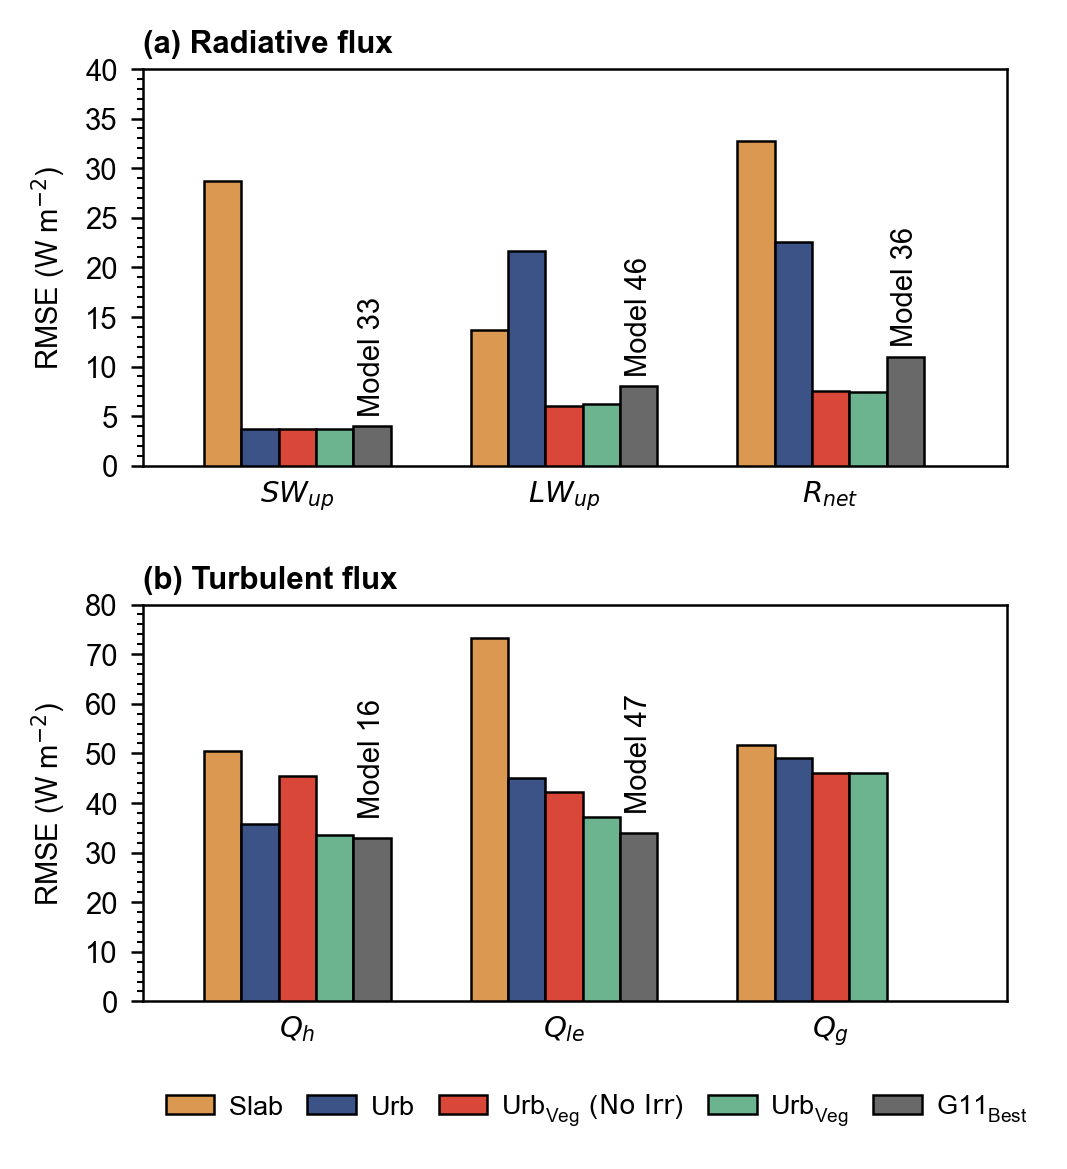

In [7]:
# Plot radiation and turbulent RMSE bars
fig = plt.figure(figsize=(3.6, 4.2), dpi=300)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

handles, labels = plot_g11(ax1, R_mod1[:, 0:3], RMSE_mod1[:, 0:3], MBE_mod1[:, 0:3], rmse_changes[0:3], 'radiation')

plot_g11(ax2, R_mod1[:, 3:],  RMSE_mod1[:, 3:],  MBE_mod1[:, 3:],  rmse_changes[3:],   'turbulent')

# Leave room for bottom legend
fig.subplots_adjust(hspace=0.35, left=0.18, right=0.98, top=0.96, bottom=0.22)

# Figure-level legend: one row, bottom center
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.6, 0.1),
    handlelength=1.8,
    handletextpad=0.5,
    columnspacing=0.9,
    prop={'size': 6.5},   # optional: keep legend compact
)

plt.savefig('Figure11.pdf', bbox_inches='tight')